<a href="https://colab.research.google.com/github/jgait/DSPS_WGaither/blob/main/HW5/FitLineToGRBAfterGlow_mcmc_DSPS23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting a line to GRB afterglow photometry

This exercise teaches you to fit the simplest model to data: a line, using different methods.

Notes:

    a line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process
    
    we will learn later that a broken powerlaw is a prefer model for the GRB afterglow. But this exercise is about fitting lines: Linear Regression
    

# initial imports

In [ ]:
import pandas as pd
import pylab as pl
import numpy as np
from sklearn.linear_model import LinearRegression
%pylab inline



Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f', 'axes', 'ndim']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Read in the input dataset
I am reading the data with Pandas. Pandas has excellent utilities for input-output of tabular data and also for time variables. We will use it throughout as our main package to acquire and manipulate data

In [ ]:
grbAG = pd.read_csv("https://raw.githubusercontent.com/fedhere/DSPS_FBianco/main/data/grb050525A.csv")
grbAG.head()

,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


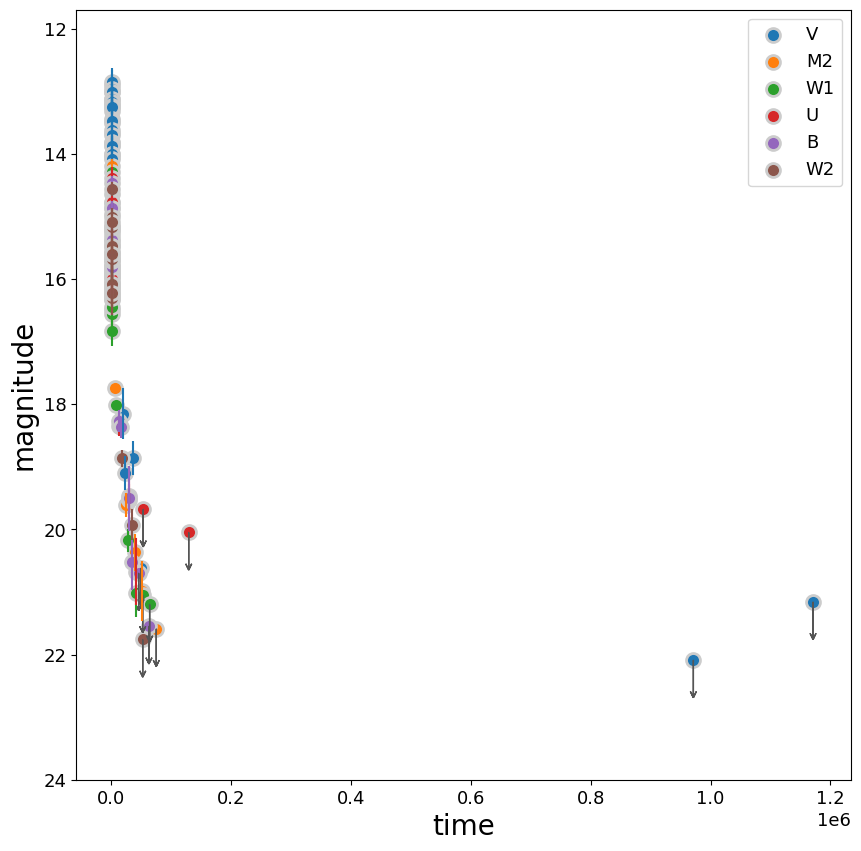

In [ ]:
#create a figure container and an axis object inside of it
ax = pl.figure(figsize=(10,10)).add_subplot(111)

#loop on every filter to plot - this will give differnt colors naturally.
#Use pl.errorbar to plot the uncertainties

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "time"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

# replot to add a better marker (optional)
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "time"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


# plot the upperlimits as arrows
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].time,
             grbAG.loc[i].mag, 0, 0.5, head_width=1e4,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
pl.ylim(24,11.7)
pl.legend()

#Always rememebr you axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("time", fontsize=20);

# Create the log-time variable

We will fit a line in log space. That corresponds to fitting a powerlaw y=x^a in natural space.


In [ ]:
grbAG['logtime'] = np.log10(grbAG['time'])
grbAG.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


# Visualize the data
The data are photometric measurements: measurement of flux from an exploding star. The flux is measured in different photometric bands, i.e. within different wavelength range. You can think about this as a filter that would limit the light collected by a camera to a single color, e.g. red, blue, or green. In most all cameras (your phone camera for example) collect data in RGB bands saparately and combine them to create a "color picture". Our eyes also perceive color in 3 bands, R, G, B.

The information about the photometric band is stored in the variable ```grbAG.filter```. Plot the data with different colors for different photometric bands.

In [ ]:
def plotlogtime(df, models=[]):
  #create a figure container and an axis object inside of it
  ax = pl.figure(figsize=(10,10)).add_subplot(111)

  #loop on every filter to plot - this will give differnt colors naturally.
  #Use pl.errorbar to plot the uncertainties

  for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

  # replot to add a better marker (optional)
  for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


  # plot the upperlimits as arrows
  nuplim = grbAG.mag.isna().sum()
  for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime,
             grbAG.loc[i].mag, 0, 0.5, head_width=0.1,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

  # I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
  pl.ylim(24,11.7)
  pl.legend()

  #Always rememebr you axis labels!!
  pl.ylabel("magnitude", fontsize=20)
  pl.xlabel("log time", fontsize=20)
  return ax

<Axes: xlabel='log time', ylabel='magnitude'>

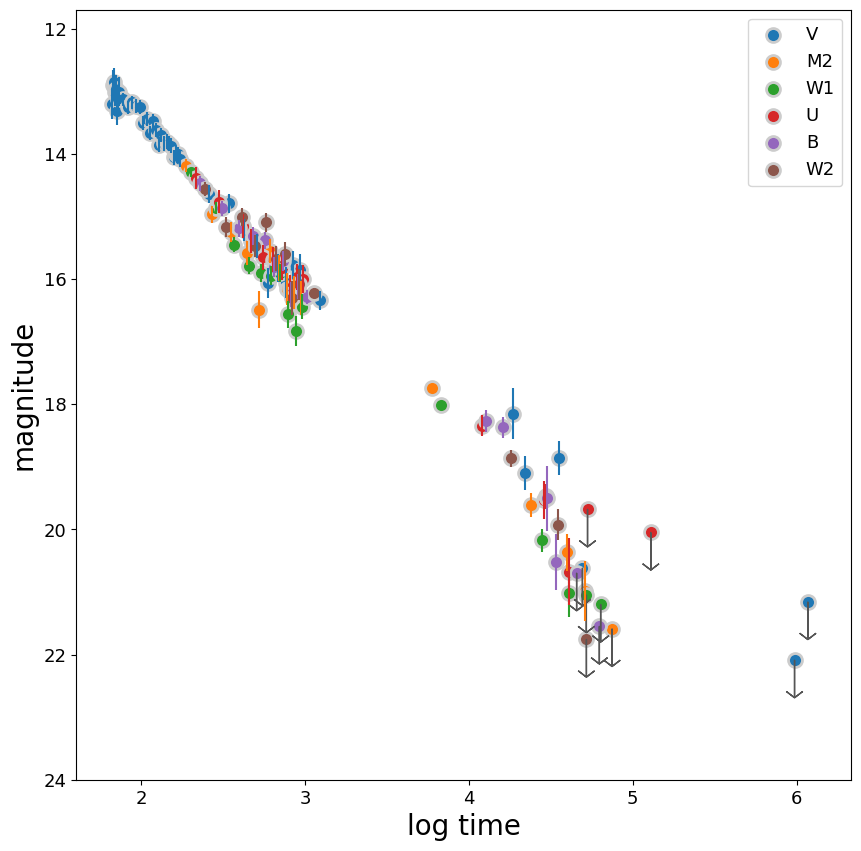

In [ ]:
plotlogtime(grbAG)

Figure 1: Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows.

# Solve using the Normal Equation

It can be shown that the best linear fit to data is given by the equation:  

$(X^T \cdot X)^{-1} \cdot X^T \cdot \vec{y}$

The solution is a tuple of 2 parameters: sloper and intercept. Therefore the input has to be Nx2


In [ ]:
x = grbAG[grbAG.upperlimit == 0].logtime.values
X = np.c_[np.ones((len(grbAG) - grbAG.upperlimit.sum(), 1)),
          x]


y = grbAG.loc[grbAG.upperlimit == 0].mag.values
print("shape of the input array X", X.shape)
print("shape of the input array y", y.shape)
#note the shape in python is flipped compared to the shape in linear algebra

shape of the input array X (108, 2)
shape of the input array y (108,)


In [ ]:
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print ("best fit parameters from the Normal Equation: " +
       "intercept {:.2f}, slope {:.2f}".format(*theta_best))

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


# Fit a line to the data (excluding the upper limits) with sklearn LinearRegression

The exogenous (independent) variable is ```grbAG.logtime```.

The information about whether the point is an upper limit or a measurement is stored in the variable ```grbAG.upperlimit```.
To remove the upper limits you can "broadcast" the data: in pandas that looks like

```grbAG.loc[grbAG.upperlimit == 0]```



In [ ]:
lr = LinearRegression()
grbAG = grbAG[grbAG.upperlimit == 0]
grbAG.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


In [ ]:
X = np.c_[np.ones(len(x)), x]
lr.fit(X, y)
print(f"Best fit with SKlearn --> Slope: {lr.coef_[1]:.3} Intercept {lr.intercept_:.3}")

Best fit with SKlearn --> Slope: 2.51 Intercept 8.58


# Fit a line to the data (excluding the upper limits) by minimizing an objective function

First, choose the L1 and L2 metric (see class notes) as the objective function.

Use ```scipy.optimize.minimize()``` to minimize it.


In [ ]:
def line(intercept, slope, x):
    return intercept+ slope*x

In [ ]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
from scipy.optimize import minimize

def line(intercept, slope, x):
  return slope * x + intercept


def l1(args, x, y):
    slope, intercept = args
    return sum(np.abs(y - (x*slope + intercept)))


initialGuess = (10,1)

l1Solution = minimize(l1, initialGuess, args=(x, y))
print(l1Solution)
print("")
print("best fit parameters from the minimization of L1: " +
       "slope {:.2f}, intercept {:.2f}".format(*l1Solution.x))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 26.30434056218986
        x: [ 2.640e+00  8.227e+00]
      nit: 11
      jac: [-1.958e+00  0.000e+00]
 hess_inv: [[ 7.594e-03 -1.591e-02]
            [-1.591e-02  3.413e-02]]
     nfev: 172
     njev: 55

best fit parameters from the minimization of L1: slope 2.64, intercept 8.23


In [ ]:

def l2(args, x, y):
    '''l2 target function: returns value of l2 for given arguments and data for a line model
    arg: (array) model arguments (parameters)
    x: the exogenous variable (array)
    y: the exogenous variable (array)
    returns L2 sum of difference between prediction and data squared
    '''
    slope, intercept = args
    return sum(np.square(y - (slope*x + intercept)))

initialGuess = (10,1)

l2Solution = minimize(l2, initialGuess, args=(x, y))
print(l2Solution)
print("")
print("best fit parameters from the minimization of L2: " +
       "slope {:.2f}, intercept {:.2f}".format(*l2Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 12.825987500725534
        x: [ 2.512e+00  8.583e+00]
      nit: 5
      jac: [-7.153e-07  1.192e-07]
 hess_inv: [[ 7.114e-03 -2.030e-02]
            [-2.030e-02  6.254e-02]]
     nfev: 21
     njev: 7

best fit parameters from the minimization of L2: slope 2.51, intercept 8.58



# Fit a line to the data (excluding the upper limits) by minimizing an objective function that accounts for the measurements uncertainties

Since the data has uncertainty, choose the $\chi^2$ (chi squared) function as your objective function.

In [ ]:
def chi2(args, x, y, s):
  # Divide the difference squared by the error squared
  sum = 0
  for i in range(len(x)):
    slope, intercept = args
    diff = y[i] - line(intercept, slope, x[i])
    sum += np.square(diff)/np.square(s[i])
  return sum

x = grbAG[grbAG.upperlimit == 0].logtime.values
y = grbAG.loc[grbAG.upperlimit == 0].mag.values
s = grbAG.loc[grbAG.upperlimit == 0].magerr.values

# Had to make this pretty close to the solution to get it to terminate successfully!
initialGuess = [2,7]

chi2Solution = minimize(chi2, initialGuess, args=(x, y, s))
print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " +
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 317.4206698013092
        x: [ 2.480e+00  8.599e+00]
      nit: 6
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[ 1.001e-04 -2.558e-04]
            [-2.558e-04  7.493e-04]]
     nfev: 33
     njev: 11

best fit parameters from the minimization of the chi squared: slope 2.48, intercept 8.60


# Plot all the solutions

Create a function that uses the parameters you input and plots a line. Add a legend that describes which line corresponds to what.


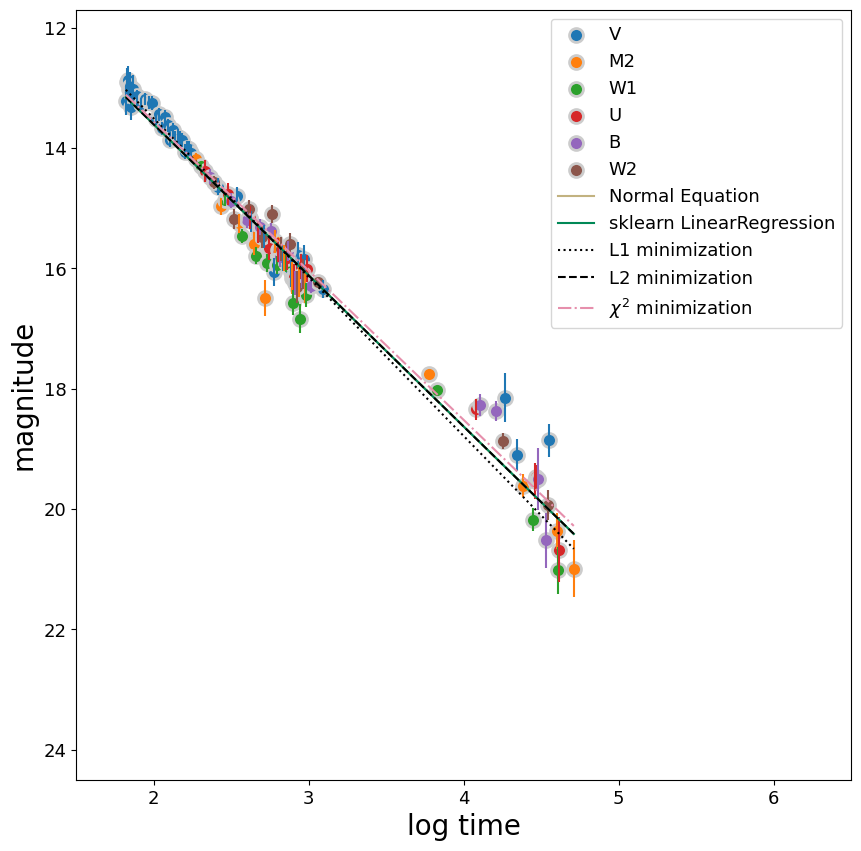

In [ ]:
def plotline(pars, x, color='k', symbol='-', label='model',
             alpha=1, ax=ax):
    slope, intercept = pars
    y = line(intercept, slope, x)
    ax.plot(x, y, ls=symbol, c=color, label=label, alpha=alpha)


ax = plotlogtime(grbAG)
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]
#normal equation
plotline((theta_best[::-1]), grbAG.logtime.values,
         color='#'+colors[0],
         label="Normal Equation", ax=ax)

#sklearn
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)

#minimize L1
plotline((l1Solution.x), grbAG.logtime,
         symbol=':',
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x), grbAG.logtime,
         symbol='--',
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x), grbAG.logtime,
         color='#'+colors[3], symbol='-.',
         label=r"$\chi^2$ minimization", ax=ax)

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);


Figure 2: Same as Figure 1, but with linear regression models plotted. The models correspond to the best fit line to the data (excluding upper limits) calculated analytically by solving the normal equation, by solving the fit analysitcally with sklearn.LinearRegression(), and by minimizing the objective functions L1 and Chi squared. The models are indicated in the legend.

# HW part 1: redo the sklearn model with a train-test split of the data

- choose the train-test rations that you prefer
- get the score for the model when predicting on the train data and on the test data
- what can you say about the model by comparing the two scores?

In [ ]:
# I know this is bad for Pep8, but since this is how we did it in class I assume I am allowed to do it here:

from sklearn.model_selection import train_test_split

In [ ]:
# Create the split with 20% going to the testing set
x_tr, x_te, y_tr, y_te = train_test_split(X, y, test_size = .2, random_state = 42)

# Create new regression object
lr2 = LinearRegression()
# Fit training data
lr2.fit(x_tr, y_tr)
# Score the fit:
training_score = lr2.score(x_tr, y_tr)

print(f'The Training set slope: {lr2.coef_[1]:0.3f} and the intercept: {lr2.intercept_:0.3f}')
print(f'The score of the Training set was : {training_score:0.3f}')

# Create new regression object
lr3 = LinearRegression()
# Fit the testing data
lr3.fit(x_te, y_te)
# Score the fit
testing_score = lr3.score(x_te, y_te)

print(f'The Testing set slope: {lr3.coef_[1]:0.3f} and the intercept: {lr3.intercept_:0.3f}')
print(f'The score of the Testing set was : {testing_score:0.3f}')




The Training set slope: 2.487 and the intercept: 8.653
The score of the Training set was : 0.971
The Testing set slope: 2.658 and the intercept: 8.197
The score of the Testing set was : 0.976


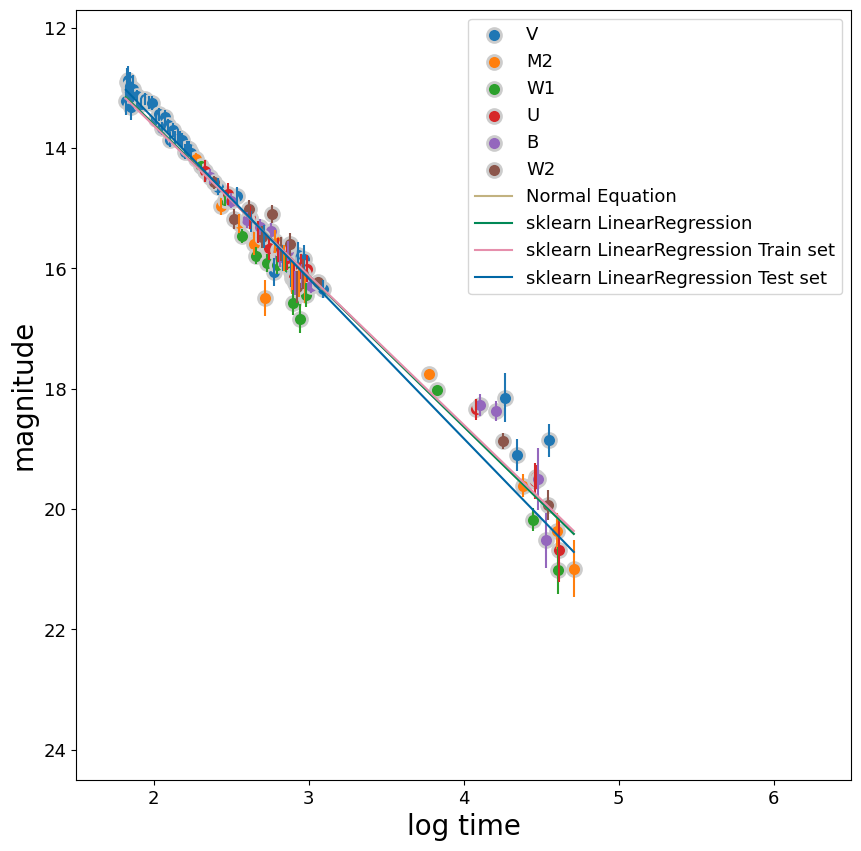

In [ ]:
# Plotting these with the other SKLearn just for fun:
def plotline(pars, x, color='k', symbol='-', label='model',
             alpha=1, ax=ax):
    slope, intercept = pars
    y = line(intercept, slope, x)
    ax.plot(x, y, ls=symbol, c=color, label=label, alpha=alpha)


ax = plotlogtime(grbAG)
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]
#normal equation
plotline((theta_best[::-1]), grbAG.logtime.values,
         color='#'+colors[0],
         label="Normal Equation", ax=ax)

#sklearn
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)

#sklearn train
plotline((lr2.coef_[1], lr2.intercept_), grbAG.logtime,
         color='#'+colors[3], symbol='-',
         label="sklearn LinearRegression Train set", ax=ax)

#sklearn test
plotline((lr3.coef_[1], lr3.intercept_), grbAG.logtime,
         color='#'+colors[4], symbol='-',
         label="sklearn LinearRegression Test set", ax=ax)

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

**Figure 3:** Same as Figure 1, but with linear regression model plotted and the split dataset linear regression models plotted. The models correspond to the best fit line to the data (excluding upper limits) calculated analytically by solving the normal equation, by solving the fit analysitcally with sklearn.LinearRegression().

# Now try a line to the data with MCMC

# HW part 2: write captions for each figure. The figures are produced by my code. The captions should state:
- what is plotted
- what is noticeable or interesting in the figure



In [ ]:
!pip install emcee # install the emcee package that implements the _affine invariant MCMC_ method

In [ ]:
import emcee #import the package

In [ ]:
emcee

<module 'emcee' from '/usr/local/lib/python3.10/dist-packages/emcee/__init__.py'>

look at documentation: https://emcee.readthedocs.io/en/stable/

We are implementing Bayes theorem to find the best model parameters: $P(\theta | D) ~ P(D | \theta) * P(\theta)$ or _Posterior ~ Likelihood * Prior_

Since we are maximizing the likelihood, we work in log space because:
- the logarithm is a monotonic function of its argument (meaning where the argument gets bigger its log gets bigger, where it gets smaller its log gets smaller)
- the log is not defined for negative values (log(something < 0) is undefined) but this does not matter because the likelihood is a probability and probabilities are positive defined.



In [ ]:
# LINE MODEL
def log_prior(theta):
  slope, intercept = theta
  if slope > 0 and intercept > 0:
    return 0
  #semi informative prior: i know light has to get fainter (mag get bigger)
  #i know i dont use negative mags
  return -np.inf


In [ ]:
#log likelihood
def log_likelihood(theta, x, y, yerr):
  slope, intercept = theta
  #chi2 likelihood : (data-model)**2 / uncertainty **2
  return -np.sum(((y - line(intercept, slope, x))**2) / yerr**2)

In [ ]:
#log posterior
def log_posterior(theta, x, y, yerr):
  lp = log_prior(theta)
  if not np.isfinite(lp):
    return -np.inf
  # posterior ~ likelihood * prior => log_posterior ~ log_likelihood + log_prior
  return lp + log_likelihood(theta, x, y, yerr)

In [ ]:
#initial guess
ig = [1,10]

In [ ]:
#initialize N walkers
nwalkers = 32
ndim = len(ig)

In [ ]:
pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim) #the starting point for each walker is a small perturbation of the initial guess

In [ ]:
pos.shape

(32, 2)

In [ ]:
# this sets up the model and assignes the hyperparameters
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y, s))

In [ ]:
# this runs the MCMC for 5,000 steps
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:13<00:00, 382.49it/s]


In [ ]:
# this extracts the ergodic markovian chains of positions in the feature space
samples = sampler.get_chain()

In [ ]:
samples.shape

(5000, 32, 2)

In [ ]:
# to get statistical properties of the chains I will concatenate the 32 chains. This works _iff_ the chains are independent
# note: the chains are _assumed_ to be independent
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

In [ ]:
#the result of the mcmc (the best parameters and their uncertainties) are statistical properties of the chains
# I recommand the median and percentiles over the mean and standard deviation, since the chains need not be gaussian
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
  mcmc[i] = np.percentile( flat_samples[:,i], [16, 50, 84])
mcmc

array([[2.46582509, 2.47997558, 2.4941725 ],
       [8.56045105, 8.59999303, 8.63949592]])

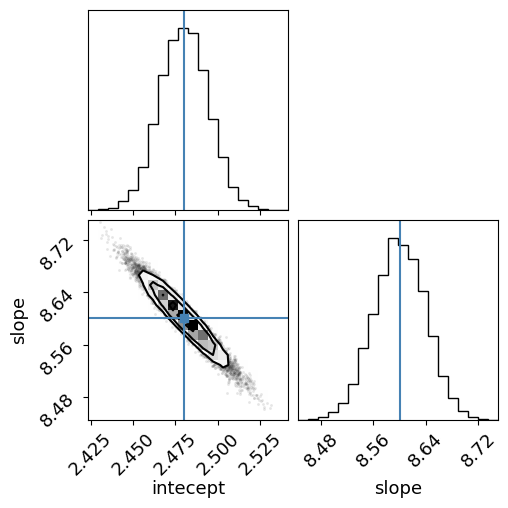

In [ ]:
#plotting the likelihood space: the panels are 2D projections of the feature space and 1D marginalized probabilities for each parameters
!pip install corner
import corner
pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["intecept", "slope"], truths=mcmc[:,1]);


**Figure 4:** Corner plot showing MCMC results, the rightmost and top plots are showing off the probability densities for the slope and intercept respecively. The most interesting plot, being the one in the lower left, shows off the region investigation for the slope and intercept values where more time would be spent in areas that are closer to the true slope and intercept values. Because this plot is very thin it shows a very strong link between the slope and intercept values.

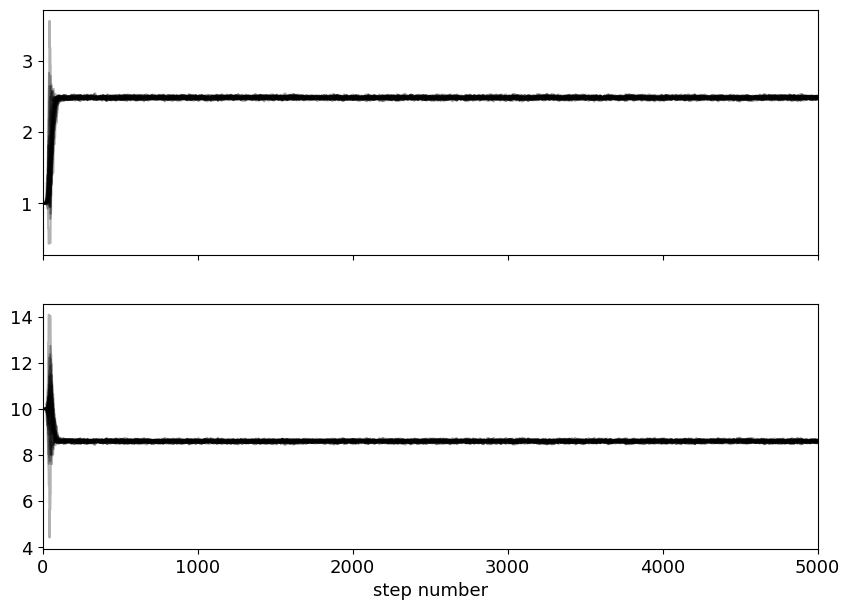

In [ ]:
# the chains should be plotted as well. in the slides and in class I discuss what you should expect them to look like
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

**Figure 5:** These two plots show off the full MCMC chains including the beginning burn in regions. As you can see by looking at those burn in regions, the initial guess was not very good but it was still able to explore enough to 'converge' (meanning spend the majority of the time not an actual convergance) on a solution.

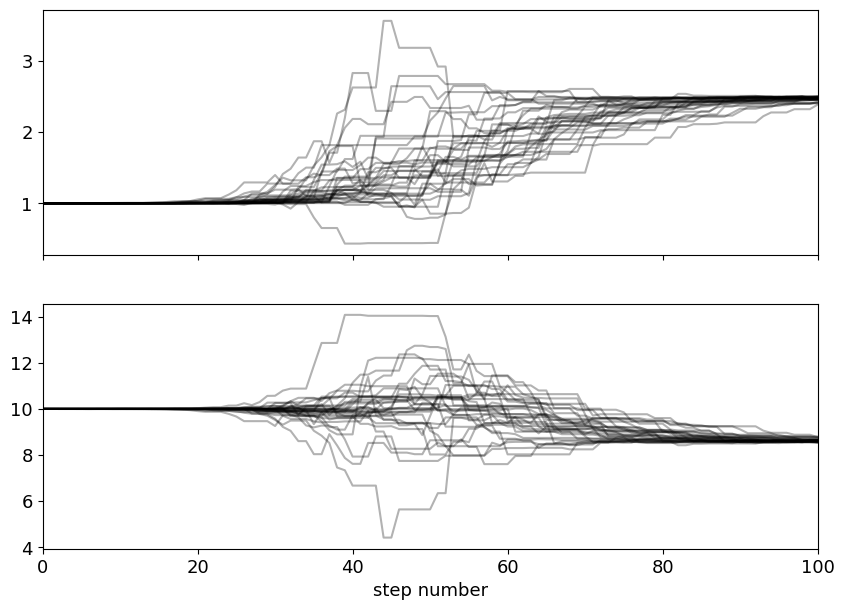

In [ ]:
# zoom in: the beginnign of the chane should be cut - this is the burn-in part of the chain
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, 100)#len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

**Figure 6:** This is the more interesting part of the graph, showing the initial ~30 samples which did not have much movement at all, then the rapid exploration of the 32 walkers. Between the 30th and 90th steps you can see how much they diverge while searching the solution space, but all end up back in a similar location.

In [ ]:
# save the mcmc results for later
mcmc_line = mcmc

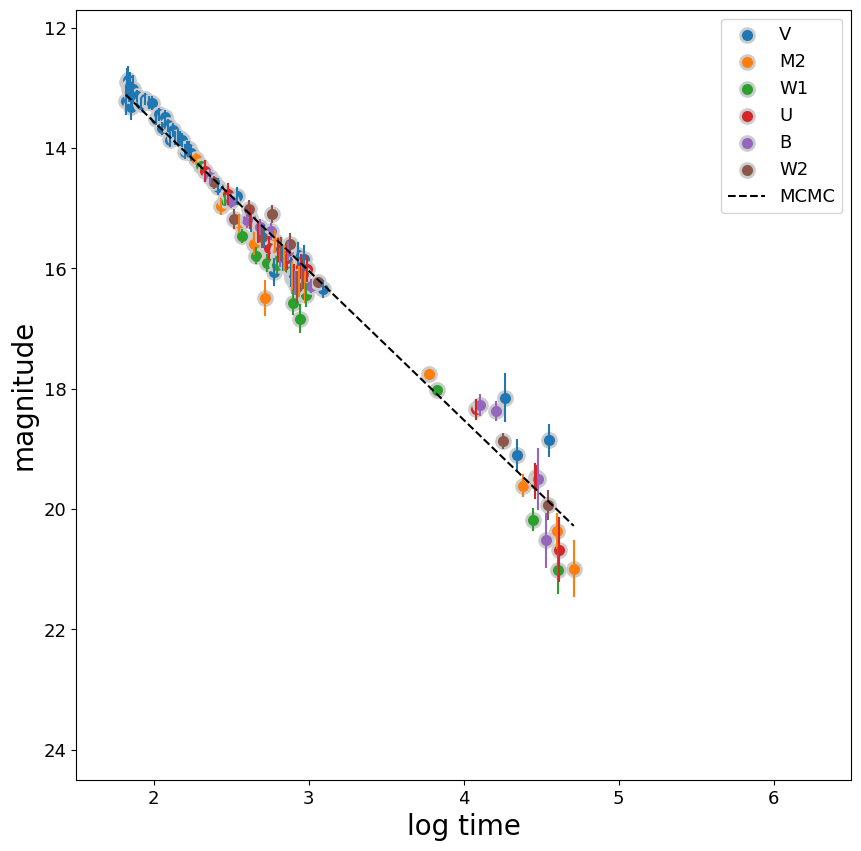

In [ ]:
labels = ["intercept","slope"]
ax = plotlogtime(grbAG)
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

pl.plot(grbAG.logtime,line(mcmc[:,1][1],mcmc[:,1][0],grbAG.logtime),
         color='k',label='MCMC',ls = '--')

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

**Figure 6:** Same as Fig. 1 but including the MCMC model, which appears to line up very well with the data and other solutions found in Figure 2.

# HW part 3

# Now try a broken power law (BPL) model

A power la is not a good model for GRB afterglows. A broken power law has been known to be a better model and has several physical motivations. In this exercise you will fit a _broke power law_ to the data, which is a more complex and higher dimensional model than the simple line fit we did so far, with MCMC getting best values for the posterior, a complete characterization of the likelihood, and allowing model selection between the line and the power law.

> Here is some info that talks about the power law model and the phsyics of GRB, which you need not know to solve the assignment but you may be interested in.  A broken power law is a power law ($y ~ x^a$) where the power a changes at some point. This can be caused by the presence of two power law processes with different, for example, where one dominates at early time and the other at late times.


>> Here is some more info that explains why we observed the GRB afterglows as broken power laws.
>>Gamma-ray bursts (GRBs) are produced by the collapse of massive stars or the merger of compact objects like neutron stars. The energy of the collapse is highly energetic (Gamma rays) but the emission gets reprocessed as it leaves the system and looses energy becoming detectable in the optical wavelengths. This is called the "optical afterglow of the GRB".
>>The explosion resulting from the collapse generates a highly relativistic outflow of material that moves at a significant fraction of the speed of light.
>> The afterglow emission is primarily produced through synchrotron radiation, where charged particles spiral around magnetic field lines. The radiation produced by synchrotrone follows a power law with an index that depends on the density of the surrounding medium, the Lorentz factor of the outflow, and the magnetic field strength. As the radiation crosses different regions of the system that collapsed these factors change and the powerlaw index changes with them.

>>If the relativistic outflow is highly collimated (a jet) as the jet expands, its emission can be modeled as a power-law light curve, but  where the jet begins to decelerate and spread out the slope of the power law changes. This transition is known as the "jet break" and results in a broken power-law behavior.

>> Some GRBs exhibit late-time flares or additional energy injection from the central engine but we are not modeling this in this exercise.




_BPL model variables:_

$F = \mathrm{flux}$ - note: not magnitude this time! $mag ~ -2.5log10(Flux)$

$t =  \mathrm{time}$ - note: not log time

_BPL model parameters:_


$T_b =  \mathrm{Time~of~break}$

$a_1:  \mathrm{Early~slope}$

$a_2: \mathrm{Late~slope}$

$b:  \mathrm{nuisance~parameters}$

_BPL model_:

in flux space the BPL model is:
$F=\frac{F_0}{ \frac{t}{T_b}^{-a1} + \frac{t}{T_b}^{-a2}}$

in magnitude space (the data you want to predict is in magnitude and the equation is simple to minimize in log space) that is:

$mag = b - log_{10}\left((\frac{t}{T_b})^{-a1} + (\frac{t}{T_b})^{-a2})\right) $



In [ ]:
t = grbAG[grbAG.upperlimit == 0].time.values

In [ ]:
t.min(), t.max()

(66, 51257)

# HW part 3 task 1:
create the model `bpl()`, the `log_likelihood()`, `log_prior()` (choose what you want to set your prior to), and `log_posterior()`

In [ ]:
def bpl (theta, x):
    """broken power law model
    Input:
      theta: (array like) 4 parameters vector, see equation
      x: (array like) independent variable
    Return:
      model predictions for each x (array like)
    """
    t = x
    # I will try my best!
    b, a_1, T_b, a_2 = theta
    # THis is kinda ugly SORRY!
    first = np.power(t/T_b, -a_1)
    second = np.power(t/T_b, -a_2)
    return b - np.log10(first + second)



In [ ]:
def log_likelihood_bpl(theta, x, y, s):
    # use the same log_likelihood as before (chi2) but with the new model
    return np.sum((np.square(y - bpl(theta, x)))/np.square(s))

def log_posterior_bpl(theta, x, y, s):
  """
  I am combining the Prior and Prosterior Functions because that just makes more
    sense to me.
  """
  # Log Prior
  b, a_1, T_b, a_2 = theta

  # Light must get fainter, No negative mags, time is positive
  if a_1 > 0 and a_2 > 0 and T_b > 0:
    # Return the posterior, in this case its just the negative of the likilihood.
    return -log_likelihood_bpl(theta, x, y, s)
  return -np.inf

# HW part 3 task 2:
Find the initial starting point as a stochastic gradient descent minimization of the log likelihood

In [ ]:

ig = [0.2, 5, 1000, 20]
#what does the minimize function need to take as arguments?
soln = minimize(log_likelihood_bpl, ig, args=(t, y, s))
soln

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 217.46531455531436
        x: [ 1.505e+01  3.548e+00  2.736e+02  2.146e+00]
      nit: 85
      jac: [-1.907e-06  3.815e-06  5.722e-06  1.907e-06]
 hess_inv: [[ 1.802e-04  3.554e-04  5.368e-04 -1.410e-04]
            [ 3.554e-04  2.377e-03  5.429e-03 -4.283e-04]
            [ 5.368e-04  5.429e-03  9.715e-02  1.300e-03]
            [-1.410e-04 -4.283e-04  1.300e-03  3.292e-04]]
     nfev: 590
     njev: 118

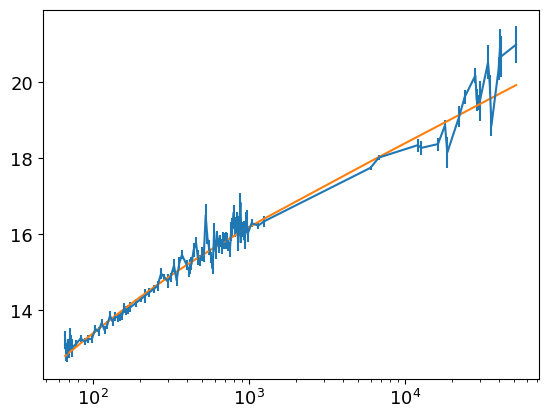

In [ ]:
ig = soln.x # the initial guess for the MCMC

# plot the model as it looks with the initial guess values
pl.errorbar(t, y, yerr=s)
pl.plot(t, bpl(ig, t))
pl.xscale("log")


**Figure 7:** Data visualization, because this fit looks quite good and makes sense based on the raw data, it is fine to accept the solution from the gradient descent as the initial guess for the MCMC

# HW 3 task 3: optimize the model wit MCMC

- set the emcee hyperparameters
- run the chains
- extract the statistical properties of the chain as the best fit values
- plot the model
- plot the marginalized posteriors of the model parameters

In [ ]:
# set the emcee hyperparameters

# Just copying this from what we did in class.
nwalkers, ndim = 32, len(ig)
pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_bpl, args=(t, y, s))

In [ ]:
# run the model, I just copied the steps from above.
sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [00:22<00:00, 220.08it/s]


State([[ 14.85464932   3.50180537 233.16086502   2.16479602]
 [ 14.8712703    3.70354582 232.11645649   2.16325351]
 [ 14.93527157   3.56341122 247.05217952   2.17621157]
 [ 14.91313087   3.61244048 247.02360785   2.17942759]
 [ 14.970786     3.70945239 254.91234507   2.16460851]
 [ 15.20599706   3.49138414 320.06845093   2.17071424]
 [ 14.65006464   3.80687283 199.46062623   2.19495917]
 [ 15.11180334   3.42266246 294.70014893   2.12876634]
 [ 15.40530588   3.36719337 366.74666328   2.09377084]
 [ 15.05746197   3.57045382 271.3728669    2.14373993]
 [ 15.17380196   3.56628597 301.929879     2.13269425]
 [ 15.12205105   3.53234028 286.58193144   2.10919204]
 [ 15.32700511   3.43730517 346.58229196   2.11015212]
 [ 15.01546198   3.57940266 269.61791595   2.15166199]
 [ 14.92527893   3.66544568 247.17806463   2.16921798]
 [ 15.5381843    3.37616661 418.89979914   2.10061566]
 [ 14.86980883   3.69040441 237.15898262   2.17771416]
 [ 15.03566673   3.63144821 270.62668731   2.15288576]
 [ 1

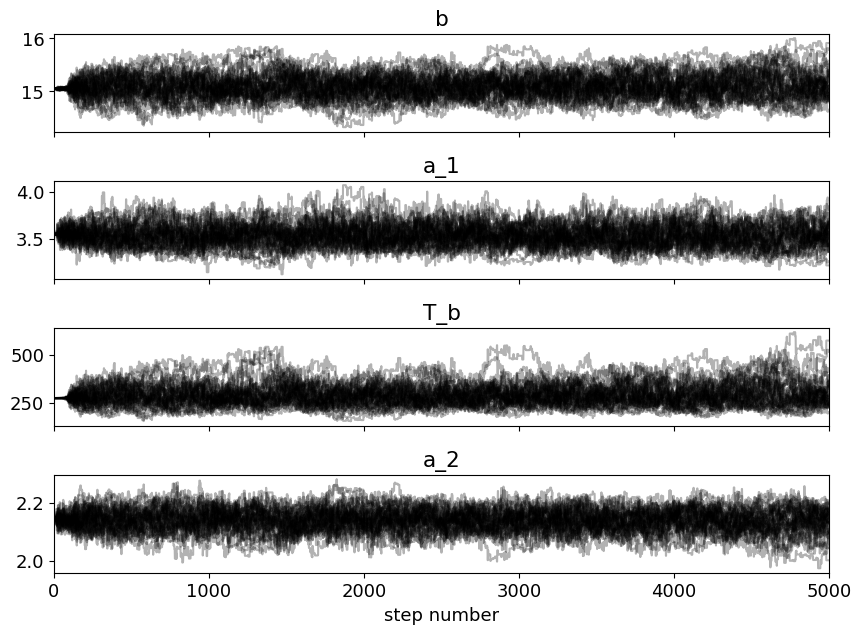

In [ ]:
#plot the chains
fig, axes = pl.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

titles = ['b', 'a_1', 'T_b', 'a_2']

for i in range(ndim):
    cur_ax = axes[i]
    # Stole this from the plots above.
    cur_ax.plot(samples[:, :, i], "k", alpha=0.3)
    cur_ax.set_xlim(0, len(samples))
    cur_ax.yaxis.set_label_coords(-0.1, 0.5)
    cur_ax.set_title(titles[i])
axes[-1].set_xlabel("step number")

# Plots kind of hit each other because of the titles, ajusted the vertical spacing
fig.subplots_adjust(hspace=0.5)

**Figure 8:** MCMC chains for the 4 given parameters, The walkers don't seem to "converge" as nicely as the MCMC chains from earlier, But if you look at the actual ranges for b, a_1, and a_2, they do actually seem to be within a very small window of values.

In [ ]:
# get the 16th, 50, and 84th percentiles of the model parameters
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
mcmc2 = np.zeros((ndim, 3))
for i in range(ndim):
    mcmc2[i] = np.percentile(flat_samples[:, i], [16, 50, 84])
mcmc2[:,1]

array([ 15.08335472,   3.5262849 , 282.08605418,   2.1410497 ])

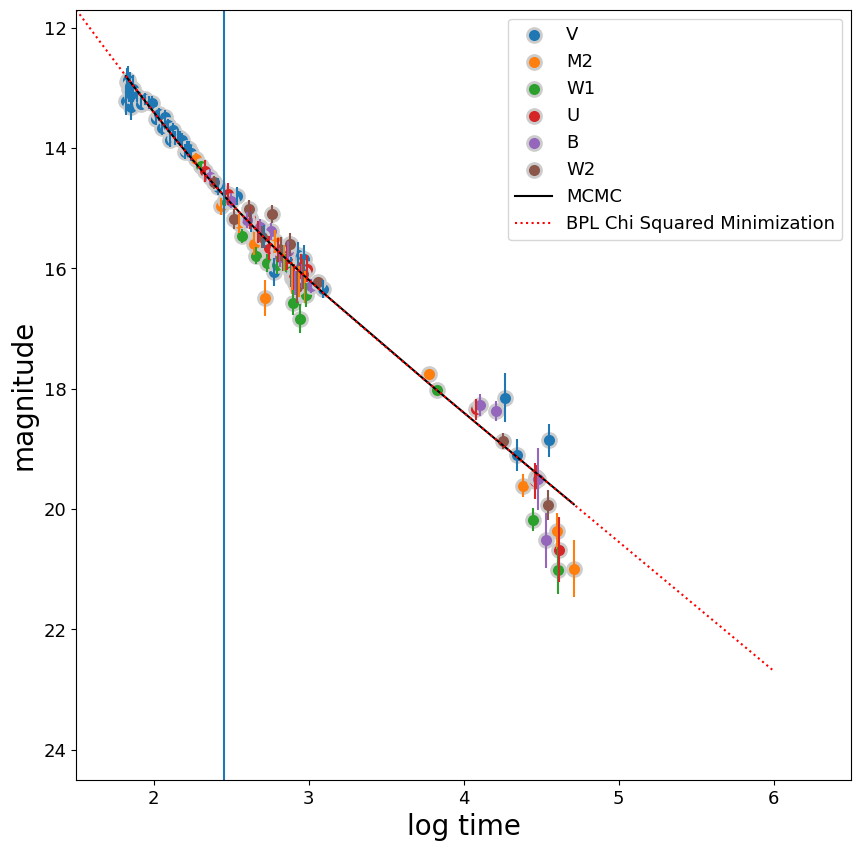

In [ ]:
#plot the model
ax = plotlogtime(grbAG)

#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

ax.plot(grbAG.logtime.values, (bpl(mcmc2[:, 1], 10**grbAG.logtime.values)),
        ls='-', color='k', label='MCMC')



pl.plot(np.arange(1.5, 6.0, 0.01),
        bpl(soln.x, 10**np.arange(1.5, 6.0, 0.01)), ls=':', color='red',
        label="BPL Chi Squared Minimization")

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')
pl.axvline(np.log10(mcmc2[2,1]))
pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

**Figure 9:** As you can see, this is the same data as the previoud figures for the afterglow but with the BPL fits for MCMC and Chi2. The two lines lay on top of each other which makes sense because the MCMC chain 'convergence' seen in the last step.

## plot the marginalized posterior distributions of the parameters

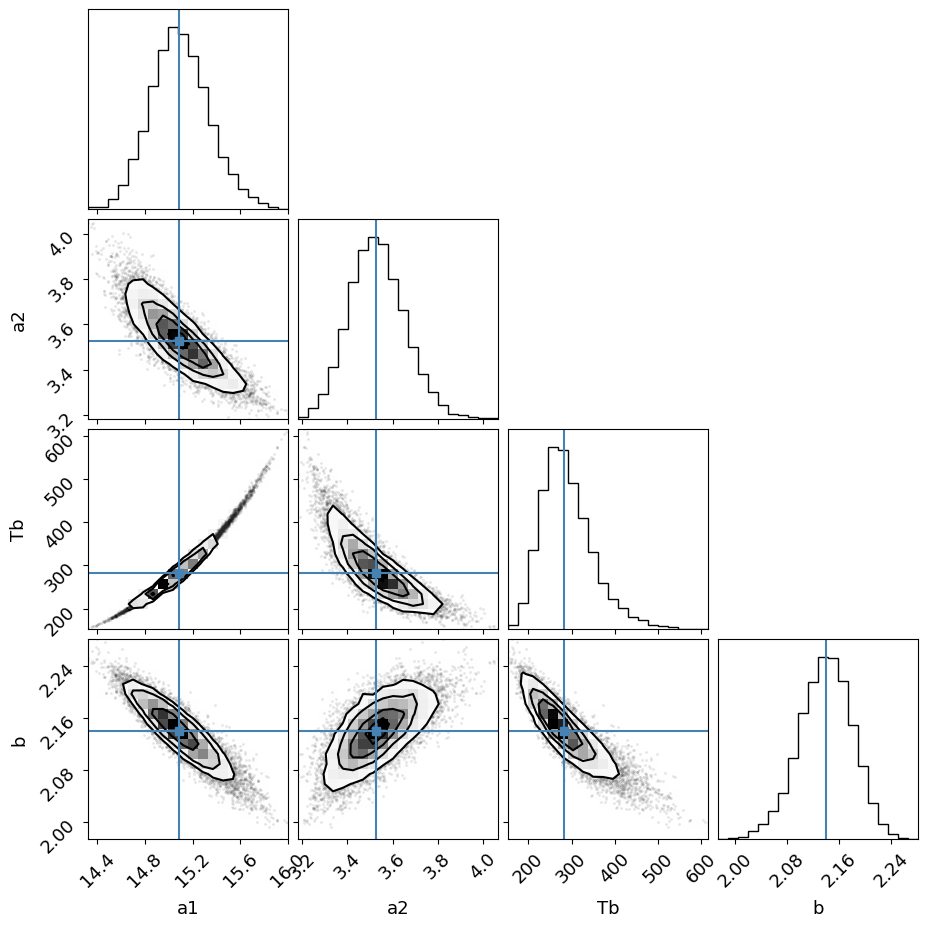

In [ ]:
pl.rcParams["font.size"] = 13
figy = corner.corner(
    flat_samples, labels=["a1", "a2", "Tb", "b"], truths=mcmc2[:,1]);



**Figure 10:** Corner plot for the BPL MCMC parameters. The contours for each parameter appear to look good and most of the graphs are slim and long meaning that there is a higher coorelation between those 2 parameters. From this it looks like b and a_2 are the least coorelated and a_1 and T_b are the most coorelated.

# HW part 4: Compare the line (as obtained by the MCMC) and broken power law models. For this part of the assignment use the slides in part 2.2 of the current slide deck (slide column 8) https://slides.com/federicabianco/dsps_6#/8. in particular:

- Print the loglikelihood of each model (you can use the log_likelihood function you had written for each)
https://slides.com/federicabianco/dsps_6#/8/1 through https://slides.com/federicabianco/dsps_6#/8/3

- implement the caluculation of the AIC (https://slides.com/federicabianco/dsps_6#/8/4 through 6)
- and BIC (https://slides.com/federicabianco/dsps_6#/8/7)



In [ ]:
line_like = log_likelihood(mcmc_line[:,1], x, y, s)
print(f'The Likelihood Ratio for the line is: {-line_like:0.3f}')

# LINE LOG LIKELIHOOD IS NEGATIVE SO I CONVERT TO POS

The Likelihood Ratio for the line is: 317.421


In [ ]:
bpl_like = log_likelihood_bpl(mcmc2[:,1], t, y, s)
print(f'The Likelihood Ratio for the BPL is: {bpl_like:0.3f}')

The Likelihood Ratio for the BPL is: 217.482


## Implement the likelihood ration test printing out the likelihood ration statistics

The likelihood-ratio test assesses the goodness of fit of two competing _nested_ statistical models based on the values of the likelihood $L$ where $M1$ is the restricted model (the parameter space is smaller, hence restricted), nested inside $M2$, the full model (the more complex one).

$ \lambda_\mathrm{LR}=-2\ln {\frac {L(M1(\theta_\mathrm{restricted}))}{L(M2(\theta_\mathrm{full}))}}$

This statistics is expexted to be $\chi2$ distributed following a $ch2$ distribution with d.o.f=difference in size of the parameter space in the two models (number of parameters in bpl model - number of parameters in line model).


In [ ]:
# Sorry again pep8

from scipy.stats.distributions import chi2

def like_ratio_statistics(LM1, LM2, dof):
  Lam_LR = -2 * np.log(LM2/LM1)
  p = chi2.sf(Lam_LR, dof)
  return p

# LINE LOG LIKELIHOOD IS NEGATIVE SO I CONVERT TO POS
like_rat = like_ratio_statistics(-line_like, bpl_like, 2)

print(f'The Likelines Ration test gives us: {like_rat:0.3f}')
print()
print('This means that the null hypothesis that the line fits better than BPL cannot be rejected.')

The Likelines Ration test gives us: 0.685

This means that the null hypothesis that the line fits better than BPL cannot be rejected.


## Calculate the AIC and BIC: Aikiki Information Criterion and Bayesian Information Criterion for the comparison of the same two models.


In [ ]:
def aic(size, like, k):
  return -2/size * like + 2/size * k


def bic(size, like, k):
  return -2 * like + np.log(size) * k


In [ ]:
print(f'AIC line {aic(len(x), line_like, 2):0.3f} - AIC bpl {aic(len(t), bpl_like, 2):0.3f}')

print(f'BIC line {bic(len(x), line_like, 2):0.3f} - BIC bpl {bic(len(t), bpl_like, 2):0.3f}')


AIC line 5.915 - AIC bpl -3.990
BIC line 644.206 - BIC bpl -425.600


AIC score and BIC score indicates that BPL is a better fit

# Extra Credit
 redefine the chi2 that I have written above to take a n deg polynomial, fit it to the data, compare it to the BPL model